# Lecture 23 Supplemental Notebook

Data 100, Spring 2023

[Acknowledgments Page](https://ds100.org/sp23/acks/)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
# import cufflinks as cf
# cf.set_config_file(offline=True, sharing=False, theme='ggplot');

from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


In [2]:
# Formatting options

# Big font helper
def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size
    plt.rcParams['font.size'] = SMALL_SIZE
    plt.rcParams['axes.titlesize'] = SMALL_SIZE
    plt.rcParams['axes.labelsize'] = MEDIUM_SIZE
    plt.rcParams['xtick.labelsize'] = SMALL_SIZE
    plt.rcParams['ytick.labelsize'] = SMALL_SIZE
    plt.rcParams['legend.fontsize'] = SMALL_SIZE
    plt.rcParams['figure.titlesize'] = BIGGER_SIZE
    
    
def savefig(fname):
    if not SAVE_FIGURES_FLAG:
        # Avoid memory overload
        return
    
    if not os.path.exists("images"):
        os.mkdir("images")
    fig = plt.gcf()
    fig.patch.set_alpha(0.0)
    plt.savefig(f"images/{fname}.png", bbox_inches = 'tight');
    
plt.rcParams['lines.linewidth'] = 3

plt.style.use('fivethirtyeight')
sns.set_context("talk")
sns.set_theme()
adjust_fontsize(20)


SAVE_FIGURES_FLAG = False

In [3]:
toy_df = pd.DataFrame({"x": [-1, -.75, -.5, -.25, .3, .4, 1, 1.2, 3],
                       "y": [ 0, 0, 0, 0, 1, 1, 1, 1, 1]})
toy_df.sort_values("x")

x  y
0 -1.00  0
1 -0.75  0
2 -0.50  0
3 -0.25  0
4  0.30  1
5  0.40  1
6  1.00  1
7  1.20  1
8  3.00  1

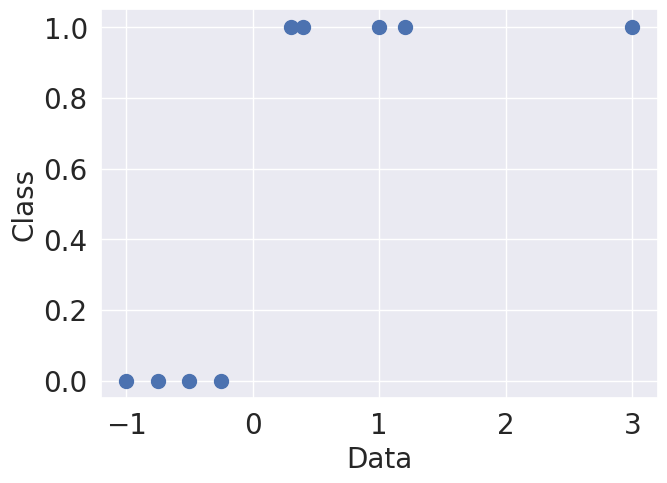

In [4]:
plt.scatter(data=toy_df, x='x', y='y', s=100);
plt.xlabel('Data')
plt.ylabel('Class');

### Outline of a classification task

The classification task includes the following steps:

1. Obtaining training data and selecting features for the classification task,
1. Learning the classification activation value $z$ based on a weighted combination of input features: $z = f_\theta(x) = \theta.x$ 
1. Using classification activation along with the decision rule to classify datapoints.

In the above example, if we assume that the only feature $x$ is used for classification and the associated weights for $f_\theta$ are $\theta_0 = 0$ and $\theta_1 = 1$, then $f_\theta(x) = z = x$.

If we choose step function with decision threshold of 0 (sign function), the following classification rule will be obtained:


$$ \text{classify}(x) = \begin{cases} 
1, &\quad\text{if}\ \  f_\theta(x) \geq 0 \\ 
0, &\quad\text{if}\ \ f_\theta(x) < 0 
\end{cases}$$


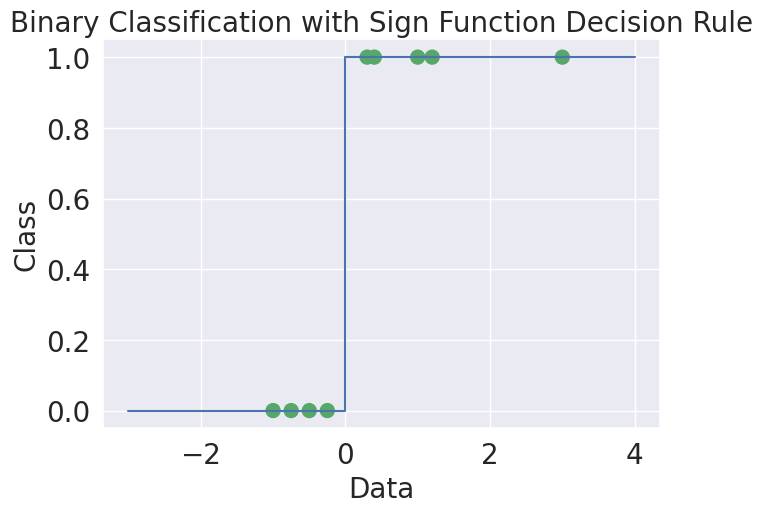

In [5]:
color_condition = (((toy_df['x']<0) & (toy_df['y']==0)) | 
                   ((toy_df['x']>=0) & (toy_df['y']==1))).astype(int)
color = np.where((color_condition==False),'r', np.where((color_condition==True),'g', 'r'))
plt.scatter(data=toy_df, x='x', y='y', s=100, c=color)
plt.xlabel('Data')
plt.ylabel('Class')
plt.step([-3,0,4], [0, 1, 1], where='post', color='b')
plt.title("Binary Classification with Sign Function Decision Rule");

### Probabilistic Modeling:

What if instead of a 0-1 output, we predict the probability of each data point belonging to the class 0 or class 1 and use the 50\% probability threshold to classify datapoints? The classifier in the probabilistic model will be:

$$ \text{classify}(x) = \begin{cases} 
1, &\quad\text{if}\ \  P_\theta(Y = 1 | x) \geq 0.5 \\ 
0, &\quad\text{if}\ \ P_\theta(Y = 1 | x) < 0.5 
\end{cases}$$

This approach enables us to evaluate the quality of the model based on: 
- How close the probability of datapoints for class 1 are to 100\%.
- How close the probability of datapoints for class 0 are to 0\%

Our goal in a probabilistic model is to train weights for the model that returns probability values $P_\hat{\theta}(Y = 1 | x)$. This probability function is a conditional probability function that outputs a probability value in the ranges of $[0,1]$ having seen the datapoint $x$.

We follow similar steps as before:

1. Obtaining training data and selecting features for the classification task,
1. Learning the classification activation value $z$ based on a weighted combination of input features: $z = f_\theta(x) = \theta.x$ 
1. Using a probabilistic function $P_\theta(Y = 1 | x) = P(Y = 1 | z)$ to output a probability value between 0 and 1. The 50\% decision rule is used to classify datapoints
    - Classify into class 0 if $P_\theta(Y = 1 | x) = P(Y = 1 | z) < 0.5$, and 
    - Classify into class 1 if $P_\theta(Y = 1 | x) = P(Y = 1 | z) >= 0.5$.

### Deriving $P(Y = 1 | z)$

The function that we are interested in finding has one input $z = \theta.x$, and outputs a probability. So the domain of the function is $(-\infty,+\infty)$ and the range of the function is $[0,1]$. What function has this attribute? Let's find out.

#### Odds

Odds is the probability of something happening divided by the probability of it not happening! If $p$ is the probability of the event hapenning, then:

$$\text{odds} = \frac{p}{1-p}$$

The odds function has probability as its input and hence its the domain is $[0,1)$ but the range of the odds function is $[0,+\infty)$. Let's see the shape of the odds function. 

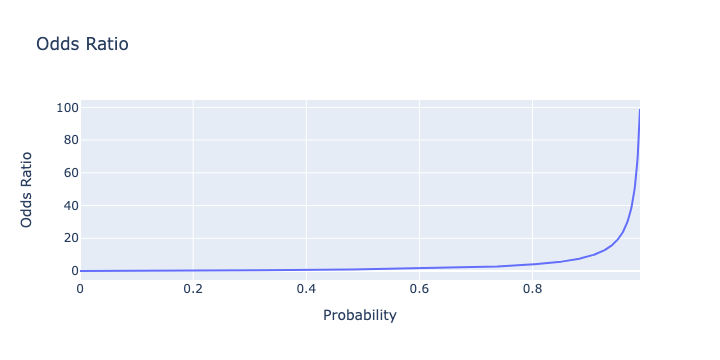

In [6]:
def odds(p):
    return p/(1-p)

p = np.linspace(0, 0.99, 1000)
odds_p = odds(p)
fig = px.line(x=p, y=odds_p, title="Odds Ratio")
fig.update_xaxes(title="Probability")
fig.update_yaxes(title="Odds Ratio")
fig.show()

#### From $[0,1]\rightarrow [0, +\infty)$ to $(0,1) \rightarrow (-\infty, +\infty)$

In the previous part, we saw how probability can be mapped into the range of all positive numbers. Now, since we are interested in using all possible classification activation values $z$ for a classification task which are in the range of $(-\infty, +\infty)$, we are interested in deriving a function that maps $[0,1]$ to $(-\infty, +\infty)$ (the inverse of what we are eventually looking for). 

How about we take the $log$ of the previous function we derived? If you take the $log$ of values in the range of $[0, +\infty)$, here is what you will get: 


$$ \text{log}(x) \in \begin{cases}
(-\infty, 0], &\quad\text{if}\ \  x \in (0,1] \\ 
(0, +\infty), &\quad\text{if}\ \ x \in (1, +\infty) 
\end{cases}$$

and hence:

$$log(\frac{p}{1-p}) \in (-\infty, +\infty)$$

This function is called **Logit Function**. Let's see how it looks like.

/tmp/ipykernel_430/1208200170.py:1: RuntimeWarning:

divide by zero encountered in log



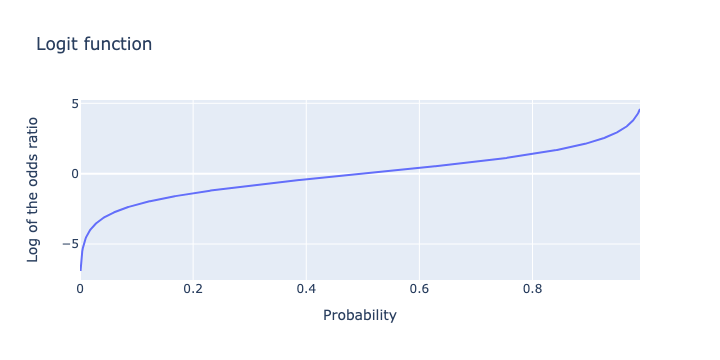

In [7]:
logit = np.log(odds_p)
fig = px.line(x=p, y=logit, title="Logit function")
fig.update_xaxes(title="Probability")
fig.update_yaxes(title="Log of the odds ratio")

#### Inversing the Logit function

Since logit function is a mapping from $(0,1)$ to $(-\infty, +\infty)$, if we inverse this function, we will get a function that can be used to map a real number (in our classification task it is classification activation $z$) to a probability value $(0,1)$.

Let's derive the inverse of the logit function:
$$
z = log(\frac{p}{1-p})\\
e^z = \frac{p}{1-p}\\
(1-p)e^z = p\\
e^z - pe^z = p\\
e^z = p + pe^z\\
e^z = p(1+e^z)\\
p = \frac{e^z}{1+e^z}\\
p = \frac{1}{1+e^{-z}}\\
$$

This function is called **Sigmoid or Logistic function** which maps a real number in $(-\infty, +\infty)$ to a probability. Let's see how this function looks like.

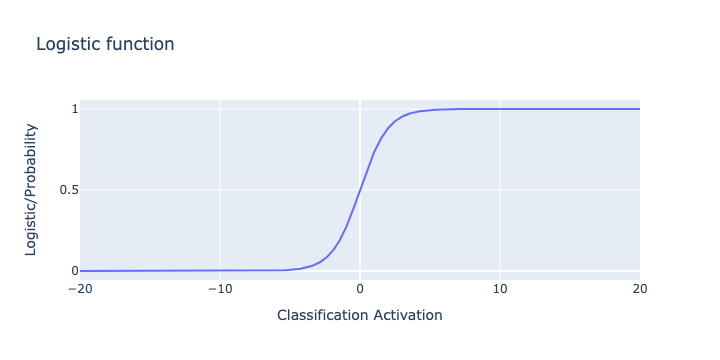

In [8]:
def logistic(z):
    return 1/(1+np.exp(-z))

z = np.linspace(-20, 20, 1000)
sig = logistic(z)
fig = px.line(x=z, y=sig, title="Logistic function")
fig.update_xaxes(title="Classification Activation")
fig.update_yaxes(title="Logistic/Probability")
fig.show()

Now let's see few logistic functions with different parameters applied to our previous dataset.

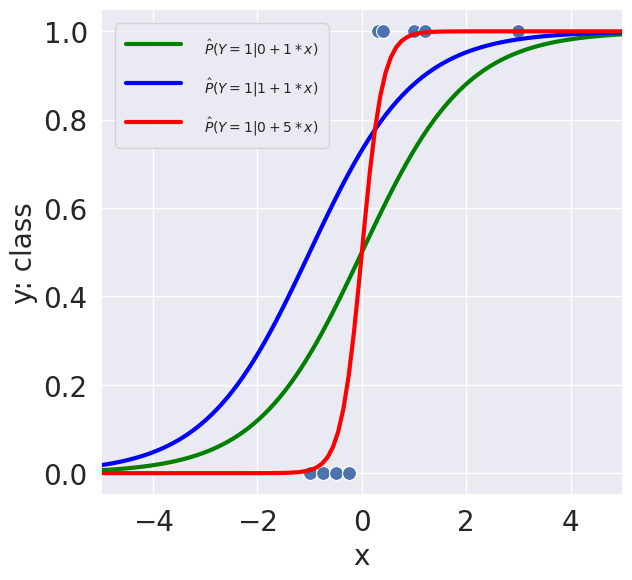

In [9]:
def sigmoid_plot(theta_0, theta_1, c):
    z = np.linspace(-5, 5, 100)
    f = sns.lineplot(x= z, y=logistic(theta_0 + theta_1 * z),
             color=c, linewidth=3,
             label= r'$\hat{P}$' + r'$(Y=1|{0} + {1}*x)$'.format(theta_0,theta_1));
    plt.setp(f.get_legend().get_texts(), fontsize='10') 


plt.figure(figsize=(6,6))
sns.scatterplot(data=toy_df, x='x', y='y', s=100)
plt.xlabel('x')
plt.ylabel('y: class')
plt.xlim((-5, 5))

sigmoid_plot(0, 1, 'green')
sigmoid_plot(1, 1, 'blue')
sigmoid_plot(0, 5, 'red')

---

### Demo on the Wisconsin Breast Cancer Dataset

For this lecture, we will use the same Wisconsin Breast Cancer Dataset from [scikit learn](http://scikit-learn.org/stable/datasets/index.html#breast-cancer-wisconsin-diagnostic-database). This dataset consists of measurements from tumor biopsies for 569 patients as well as whether the tumor was malignant or benign.

In [10]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
data = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
data

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
0             0.27760         0.30010              0.14710         0.2419   
1             0.07864         0.08690              0.07017         0.1812   
2             0.15990         0.19740              0.12790         0.2069   
3             0.28390         0.24140              0.10520         0.2597   
4             0.13280         0.19800              0.10430         0.1809   
..                ...             ...                  ...            ...   
564           0.11590         0.24390              0.13890         0.1726   
565           0.10340         0.14400              0.09791         0.1752   
566           0.10230         0.09251              0.05302         0.1590   
567           0.27700         0.35140              0.15200         0.2397   
568           0.04362         0.00000              0.00000         0.1587   

     mean fractal dimension  ...  worst radius  worst texture  \
0                   0.07871  ...        25.380          17.33   
1                   0.05667  ...        24.990          23.41   
2                   0.05999  ...        23.570          25.53   
3                   0.09744  ...        14.910          26.50   
4                   0.05883  ...        22.540          16.67   
..                      ...  ...           ...            ...   
564                 0.05623  ...        25.450          26.40   
565                 0.05533  ...        23.690          38.25   
566                 0.05648  ...        18.980          34.12   
567                 0.07016  ...        25.740          39.42   
568                 0.05884  ...         9.456          30.37   

     worst perimeter  worst area  worst smoothness  worst compactness  \
0             184.60      2019.0           0.16220            0.66560   
1             158.80      1956.0           0.12380            0.18660   
2             152.50      1709.0           0.14440            0.42450   
3              98.87       567.7           0.20980            0.86630   
4             152.20      1575.0           0.13740            0.20500   
..               ...         ...               ...                ...   
564           166.10      2027.0           0.14100            0.21130   
565           155.00      1731.0           0.11660            0.19220   
566           126.70      1124.0           0.11390            0.30940   
567           184.60      1821.0           0.16500            0.86810   
568            59.16       268.6           0.08996            0.06444   

     worst concavity  worst concave points  worst symmetry  \
0             0.7119                0.2654          0.4601   
1             0.2416                0.1860          0.2750   
2             0.4504                0.2430          0.3613   
3             0.6869                0.2575          0.6638   
4             0.4000                0.1625          0.2364   
..               ...                   ...             ...   
564           0.4107                0.2216         

#### The Prediction Task

The prediction task for this data is to predict whether a tumor is benign or malignant (a binary decision) given characteristics of that tumor. As a classic machine learning dataset, the prediction task is captured by the column named `"target"`. Target data_dict['target'] = 0 is malignant 1 is benign
`data['malignant'] = (data_dict['target'] == 0).astype(int)` is used to put the data back in its original context which will be 1 if the tumor is malignant and 0 if it is benign (reversing the definition of target).  

In [11]:
# Target data_dict['target'] = 0 is malignant 1 is benign
data['malignant'] = (data_dict['target'] == 0).astype(int)

#### Selecting Features

What features might be a good indication of whether a tumor is benign or malignant? 

In [12]:
data.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'malignant'],
      dtype='object')

In [13]:
data[['mean radius', 'malignant']]

mean radius  malignant
0          17.99          1
1          20.57          1
2          19.69          1
3          11.42          1
4          20.29          1
..           ...        ...
564        21.56          1
565        20.13          1
566        16.60          1
567        20.60          1
568         7.76          0

[569 rows x 2 columns]

Perhaps a good starting point is the size of the tumor.  Larger tumors are probably more likely to be malignant.  In the following, we plot whether the tumor was malignant (1 or 0) against the `"mean radius"`.

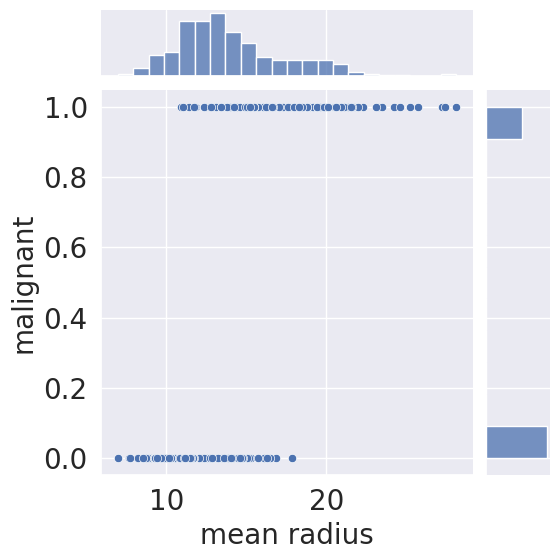

In [14]:
sns.jointplot(data = data, x = "mean radius", y = "malignant");

This is a clear example of over-plotting.  We can improve the above plot by jittering the data:

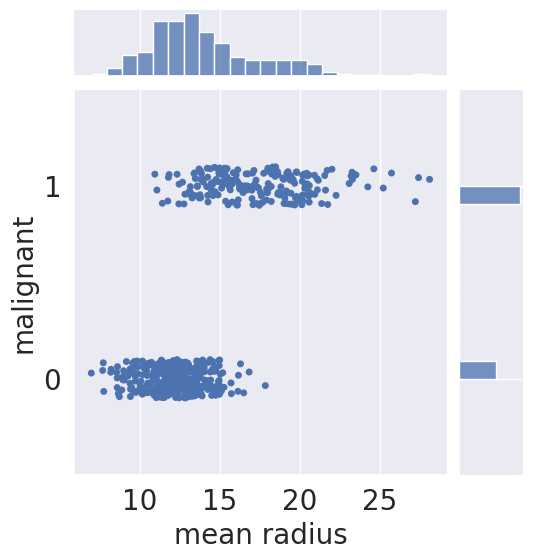

In [15]:
# Manual to allow for jitter
g = sns.JointGrid(data = data, x = "mean radius", y = "malignant")
g.plot_marginals(sns.histplot)
g.plot_joint(sns.stripplot,
             orient='h', order=[1, 0],
             color=sns.color_palette()[0])
(g.ax_joint).set_xticks([10, 15, 20, 25])
plt.show()

Perhaps a better way to visualize the data is using stacked histograms.

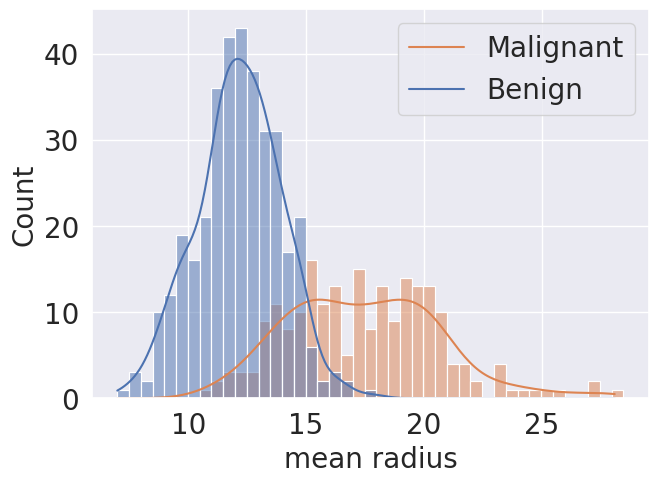

In [16]:
sns.histplot(data = data, x = "mean radius", 
             hue = "malignant",
             binwidth=0.5,
             kde=True);
plt.legend(labels=["Malignant", "Benign"]);

**Question:** Looking at the above histograms could you describe a rule to predict whether or a cell is malignant?

In [17]:
from sklearn.model_selection import train_test_split

data_tr, data_te = train_test_split(data, test_size=0.10, random_state=42)
data_tr.reset_index(inplace=True, drop=True)
data_te.reset_index(inplace=True, drop=True)
print("Training Data Size: ", len(data_tr))
print("Test Data Size: ", len(data_te))

Training Data Size:  512
Test Data Size:  57


Creating the `X` and `Y` matrices for the training data:

In [18]:
# X, Y are training data
X = data_tr[['mean radius']].to_numpy()
Y = data_tr['malignant'].to_numpy()

#### Best model parameters
What's the best model that fits our data? We will discuss this in the next section.

---

<br/><br/><br/>

### sklearn

The `linear_model.LogisticRegression` model ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) is what we want to use here. In order to recreate our specific model, there are a few parameters we need to set:
- `penalty = 'none'`: by default, `LogisticRegression` uses regularization. This is generally a good idea, which we'll discuss later.
- `fit_intercept = True`: our toy model currently has an intercept term.
- `solver = 'lbgfs'`: need to specify a numerical optimization routine for the model (similar to gradient descent). `lbfgs` is one such type; it's the new default in `scikit-learn`.

<br/>

#### Fit

We'll fit a model with the mean radius feature and a bias intercept. So $\theta = (\theta_0, \theta_1)$ and our model is:

$$\hat{P}_{\theta} (Y = 1 | x) = \sigma(x^T\theta) = \sigma(\theta_0 + \theta_1 x_1)$$

In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=True)
model.fit(X, Y); # X, Y are training data

<br/>

Optimal $\theta_0, \theta_1$ from fitting our model:

In [20]:
model.intercept_, model.coef_

(array([-14.42394402]), array([[0.97889232]]))

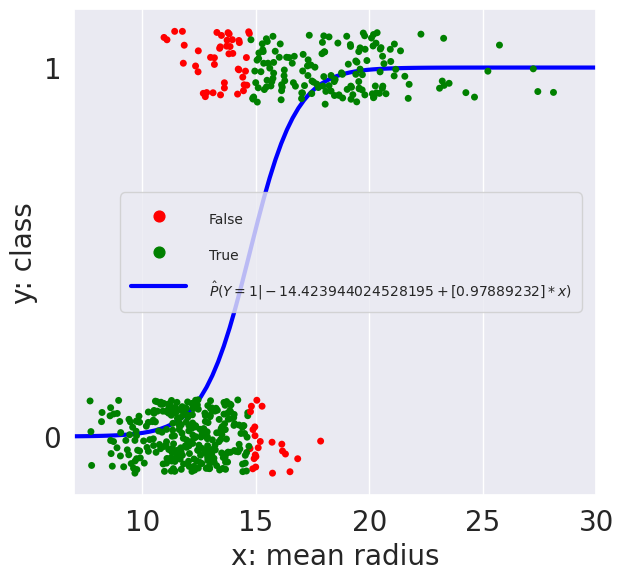

In [21]:
plt.figure(figsize=(6,6))
# Getting model parameters
theta_0 = model.intercept_[0]
theta_1 = model.coef_[0]

# Getting model predictions
y_pred = np.round(logistic(theta_0 + theta_1 * data_tr['mean radius']))

# Setting colors based on correct and incorrect y_pred
color_palette = {False:'red', True:'green'}
sns.stripplot(x=data_tr['mean radius'].squeeze(), y=data_tr['malignant'], 
              jitter = 0.1, orient='h', hue= y_pred==data_tr['malignant'], palette = color_palette);

plt.gca().invert_yaxis()
plt.xlabel('x: mean radius')
plt.ylabel('y: class')
plt.xlim((7, 30))

# Plotting the sigmoig function with the given parameters
z = np.linspace(5, 30, 100)
f = sns.lineplot(x= z, y=logistic(theta_0 + theta_1 * z),
                 color='blue', linewidth=3,
                 label= r'$\hat{P}$' + r'$(Y=1|{0} + {1}*x)$'.format(theta_0,theta_1))
plt.setp(f.get_legend().get_texts(), fontsize='10');

<br/>

#### Prediction


**Predict probabilities**: `scikit-learn` has a built-in `.predict_proba` method that allows us to get the predicted probabilities under our model. The `.classes_` attribute stores our class labels.

In [22]:
model.predict_proba([[20]])

array([[0.00574364, 0.99425636]])

In [23]:
model.classes_

array([0, 1])

<br/><br/>

Let's visualize these probabilities on our train dataset, `X` and `y`.

In [24]:
Prob_hat_one = model.predict_proba(X)[:, 1]
Prob_hat_one.shape

(512,)

The seaborn function `stripplot` auto-plots jittered data by class.

Text(0, 0.5, 'y: class')

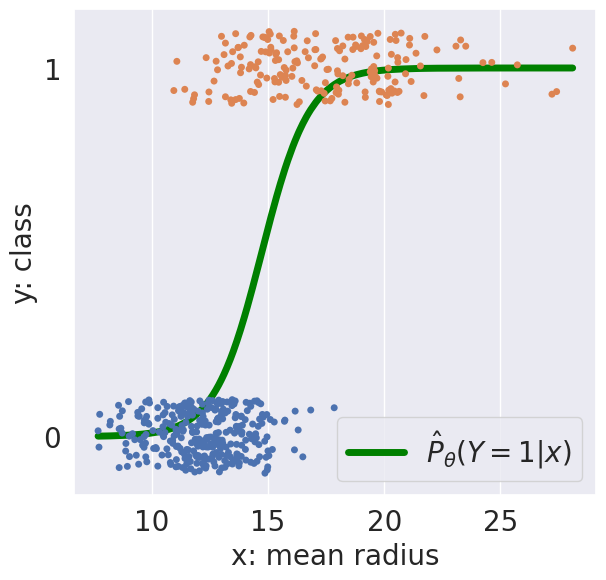

In [25]:
plt.figure(figsize=(6,6))
sns.stripplot(x=X.squeeze(), y=Y, 
              jitter = 0.1, orient='h');
sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.xlabel('x: mean radius')
plt.ylabel('y: class')

<br/>

**Predict class labels**: By comparison, what does `.predict()` do?

It predicts 1 if the computed probability for class 1 is greater than 0.5, and 0 otherwise.

$$\text{classify}(x) = \begin{cases} 1, & P(Y = 1 | x) \geq 0.5 \\ 0, & \text{otherwise} \end{cases}$$

This is what we call **classification**.

Edit the above cells to see sklearn's prediction for a mean radius of `10`.

In [26]:
model.predict([[20]])

array([1])

### Logistic Regression with Squared Loss

We've chosen a model. It's now time to choose a loss function. Why not squared loss?

In [27]:
def mse_loss_train_nobias(theta):
    x = data_tr['mean radius']
    y_obs = data_tr['malignant']
    y_hat = logistic(x * theta)
    return np.mean((y_hat - y_obs) ** 2)  

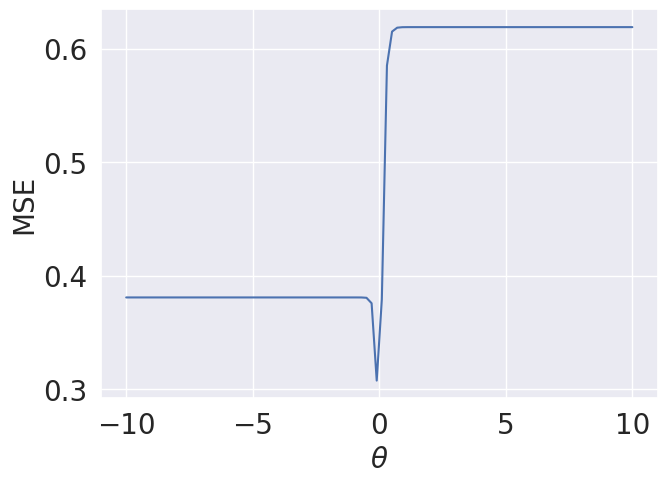

In [28]:
thetas = np.linspace(-10, 10, 100)
plt.plot(thetas, [mse_loss_train_nobias(theta) for theta in thetas])
plt.ylabel('MSE')
plt.xlabel(r'$\theta$');

<br/><br/>

What????

#### Toy Dataset: L2 Loss

Consider this manufactured dataset.

In [29]:
toy_df = pd.DataFrame({
        "x": [-4, -2, -0.5, 1, 3, 5],
        "y": [0, 0, 1, 0, 1, 1]
})
toy_df.sort_values("x")

x  y
0 -4.0  0
1 -2.0  0
2 -0.5  1
3  1.0  0
4  3.0  1
5  5.0  1

Text(0.5, 1.0, 'Toy classification data')

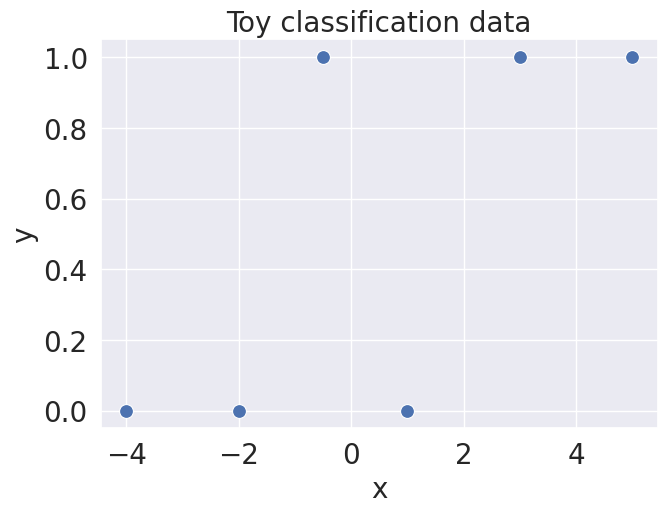

In [30]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100)
plt.title("Toy classification data")

Let's plot the loss surface for this toy data using squared loss with the model $\hat{p} = \sigma(\theta x)$. We don't include an intercept term, so $\theta$ and $x$ are both scalars.

Text(0, 0.5, 'MSE')

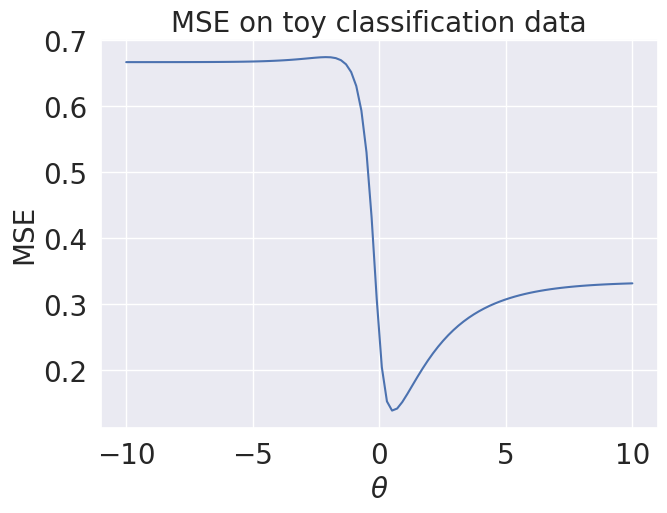

In [31]:
def mse_loss_toy_nobias(theta):
    p_hat = logistic(toy_df['x'] * theta)
    return np.mean((toy_df['y'] - p_hat)**2)

thetas = np.linspace(-10, 10, 100)
plt.plot(thetas, [mse_loss_toy_nobias(theta) for theta in thetas])
plt.title("MSE on toy classification data");
plt.xlabel(r'$\theta$')
plt.ylabel('MSE')

This loss surface is not convex! Depending on where we start our optimization search, we'll end up with different results. Let's explore with `scipy.optimize.minimize`.

In [32]:
best_theta = minimize(mse_loss_toy_nobias, x0 = 0)["x"][0]
best_theta

0.5446601825581691

Remember, our 1-D model with no intercept is $\hat{p} = \sigma(\theta x)$.

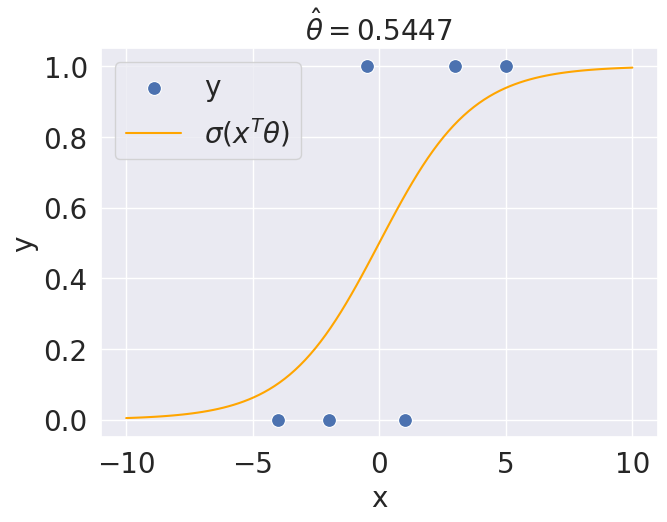

In [33]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100, label='y')
xs = np.linspace(-10, 10, 100)
plt.plot(xs, logistic(xs * best_theta), color='orange', label=r'$\sigma(x^T \theta)$')
plt.xlabel('x')
plt.legend()
plt.title(r'$\hat{\theta} = $' + f"{best_theta:.4}");

<br/>
Let's try another starting point for minimizing theta.

In [34]:
best_theta_2 = minimize(mse_loss_toy_nobias, x0 = -5)["x"][0]
best_theta_2

-10.343653061026611

Uhhh, looks like the optimizer got stuck.

Text(0.5, 1.0, '$\\hat{\\theta} = $-10.34')

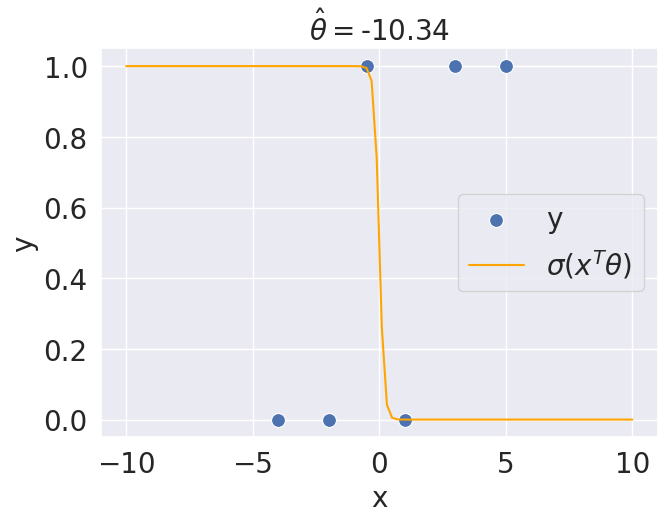

In [35]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100, label='y')
xs = np.linspace(-10, 10, 100)
plt.plot(xs, logistic(xs * best_theta_2), color='orange', label=r'$\sigma(x^T \theta)$')
plt.xlabel('x')
plt.legend()
plt.title(r'$\hat{\theta} = $' + f"{best_theta_2:.4}")

Not only is it not convex, leading to the weird issues above, but squared loss just isn't well-suited for a probability task. Since $\hat{p}_i$ is between 0 and 1, and $y_i$ is either 0 or 1, the squared loss for a single point $(y_i - \hat{p}_i)^2$ is bounded between 0 and 1.

What this means in practice: even if our prediction is terrible, the squared loss is never that large.

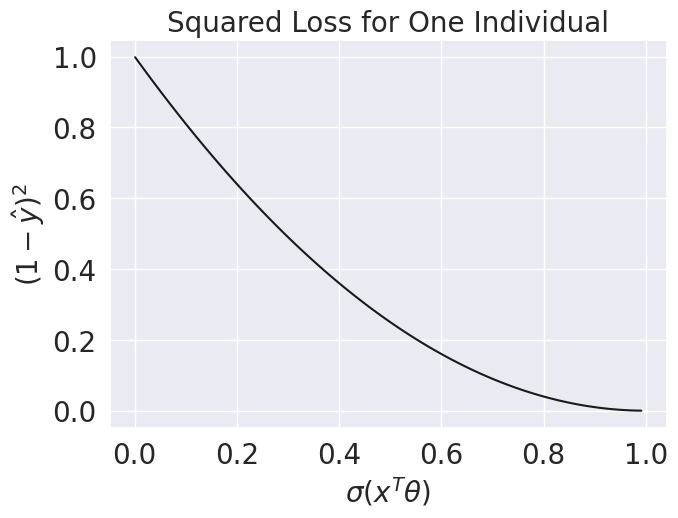

In [36]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = (1 - p_hat)**2
plt.plot(p_hat, loss, color='k')
plt.xlabel(r'$\sigma({x^T \theta})$')
plt.ylabel(r'$(1 - \hat{y})^2$')
plt.title('Squared Loss for One Individual');

### Motivating Cross-Entropy Loss

Let's look at a new loss, called the log loss, for when our true observation is 1.

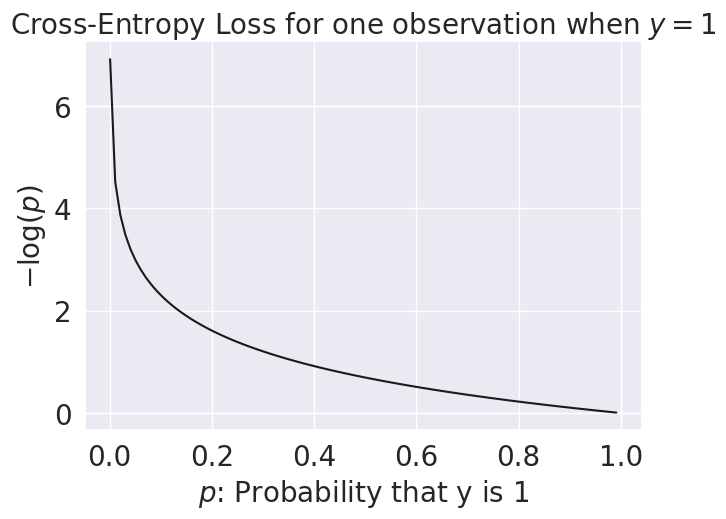

In [37]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$p$: Probability that y is 1')
plt.ylabel('$-\log(p)$')
plt.title('Cross-Entropy Loss for one observation when $y = 1$');

We can see that this penalizes wrong predictions far more than squared loss does.

How to read this plot: Suppose the observation we're trying to predict is actually in class 1. If our model gives an 80% chance of being in class 1, the loss is relatively small (around 0.25). 

If we give only a 40% of being in class 1, the loss is larger (around 1).

If we give only a 5% chance of being in class 1, the loss is 3.

And if we give a 0% chance of being in class 1, the loss is infinite.

What about when the true observation is 0?

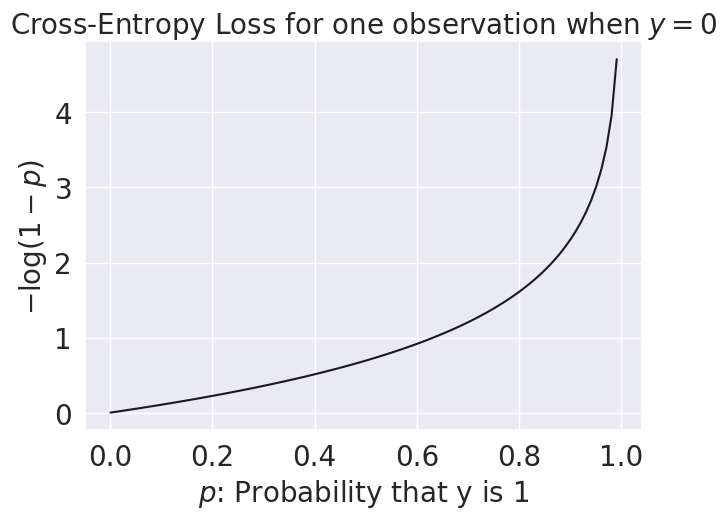

In [38]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(1 - p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$p$: Probability that y is 1')
plt.ylabel('$-\log(1 - p)$')
plt.title('Cross-Entropy Loss for one observation when $y = 0$');

Much of the formal derivation is in the slides. But the equation for cross-entropy loss for a single observation is

$$\textrm{loss} = -y \log(\hat{y}) - (1-y)\log(1-\hat{y})$$

For us, since $\hat{y} = \sigma(x^T \theta)$, the expression for average cross-entropy loss is

$$R(\theta) = -\frac{1}{n} \sum_{i = 1}^n \big(y_i \log (\sigma(\mathbb{X}_i^T \theta)) + (1 - y_i) \log (1 - \sigma(\mathbb{X}_i^T \theta))\big)$$

Let's look at the loss surface for average cross-entropy loss, on our toy data from before.

In [39]:
def cross_entropy(y, phat):
    return - y * np.log(phat) - (1 - y) * np.log(1 - phat)

In [40]:
def mce_loss_toy_nobias(theta):
    p_hat = logistic(toy_df['x'] * theta)
    return np.mean(cross_entropy(toy_df['y'], p_hat))

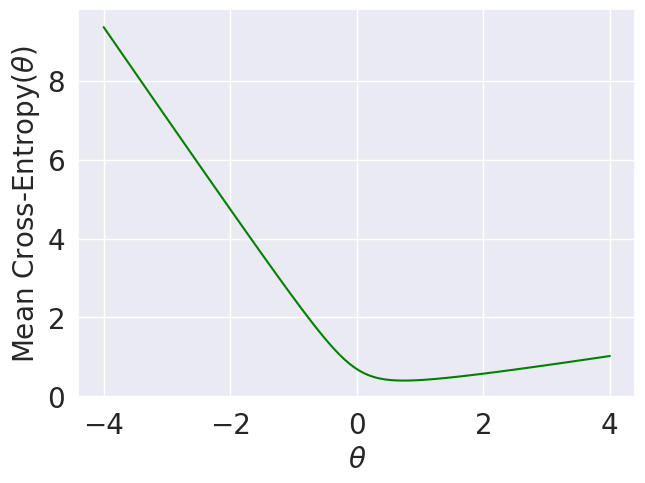

In [41]:
thetas = np.linspace(-4, 4, 100)
plt.plot(thetas, [mce_loss_toy_nobias(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy($\theta$)')
plt.xlabel(r'$\theta$');